In [1]:
import numpy as np
import scipy

import cupy as cp
import cupyx.scipy

import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output, display, HTML
display(HTML("<style>.container { width:90% !important; }</style>")) # just making the notebook cells wider
from datetime import datetime

today = int(datetime.today().strftime('%Y%m%d'))

from importlib import reload
import time

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import cgi_phasec_poppy

from math_module import xp, ensure_np_array
import iefc_2dm 
import utils
from imshows import *

data_dir = iefc_2dm.iefc_data_dir
response_dir = data_dir/'response-data'

dm1_flat = fits.getdata(cgi_phasec_poppy.data_dir/'dm-acts'/'flatmaps'/'spc_wide_band4_flattened_dm1.fits')
dm2_flat = fits.getdata(cgi_phasec_poppy.data_dir/'dm-acts'/'flatmaps'/'spc_wide_band4_flattened_dm2.fits')



INFO:numexpr.utils:Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


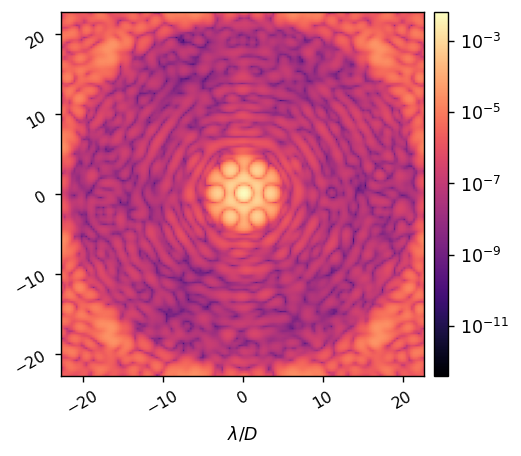

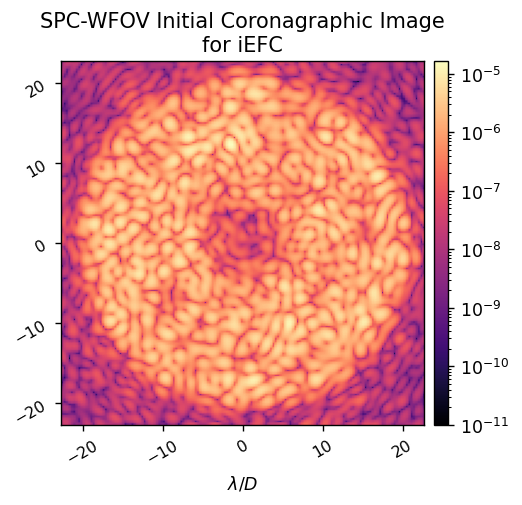

In [3]:
mode = cgi_phasec_poppy.cgi.CGI(cgi_mode='spc-wide', npsf=150,
                                  use_pupil_defocus=True, 
                                  use_opds=True,
                                  dm1_ref=dm1_flat, dm2_ref=dm2_flat,
                                  )
mode.use_fpm = False
ref_unocc_im = mode.snap()
imshow1(ref_unocc_im, pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True)

mode.Imax_ref = ref_unocc_im.get().max()
mode.use_fpm = True

ref_im = mode.snap()
imshow1(ref_im, 'SPC-WFOV Initial Coronagraphic Image\nfor iEFC',
        pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True, vmin=1e-11)

# Create dark hole ROI to calibrate and control

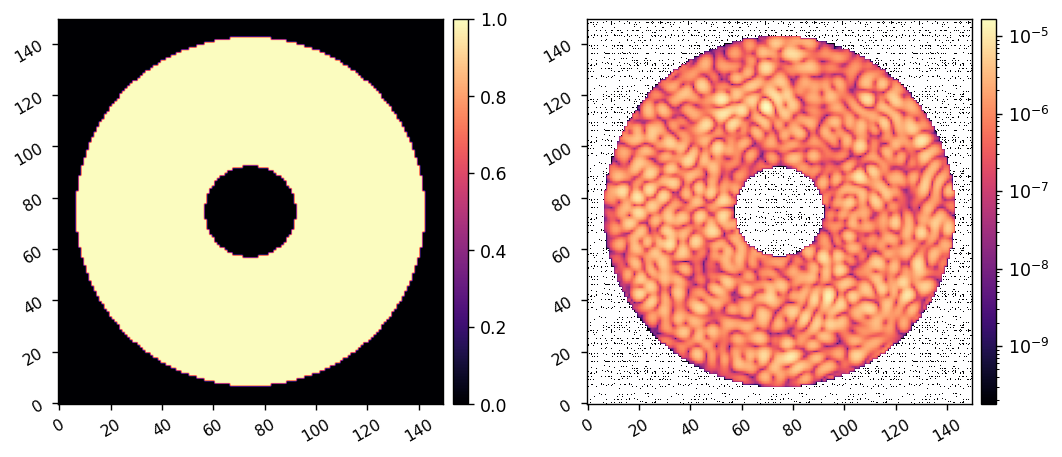

1.409806746664682e-06


In [4]:
reload(utils)
control_mask = utils.create_annular_focal_plane_mask(mode, inner_radius=5.4, outer_radius=20.6, edge=None)

imshow2(control_mask, control_mask*ref_im, lognorm2=True)
mean_ni = xp.mean(ref_im[control_mask])
print(mean_ni)

# Create calibration and probe modes

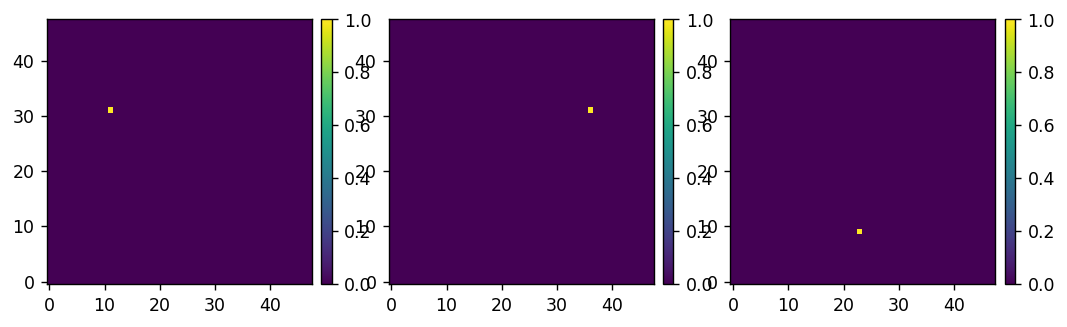

In [5]:
probe_amp = 2.5e-8
# probe_modes = utils.create_poke_probes([(10,34), (38,34), (24,10)], plot=True)
probe_modes = utils.create_poke_probes([(11,31), (36,31), (23,9)], plot=True)

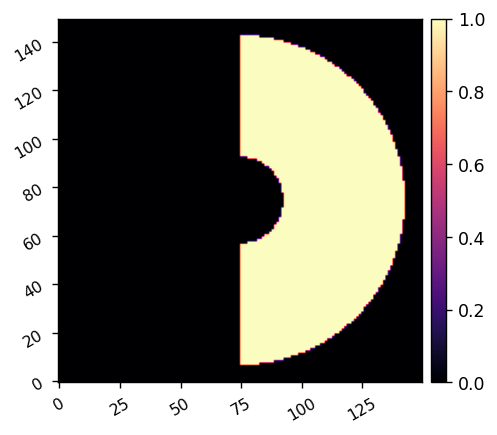

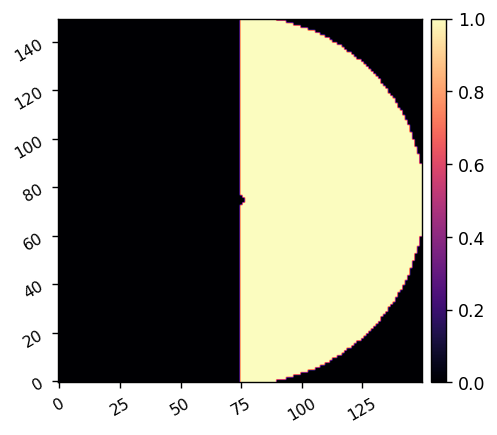

(3480, 4608)


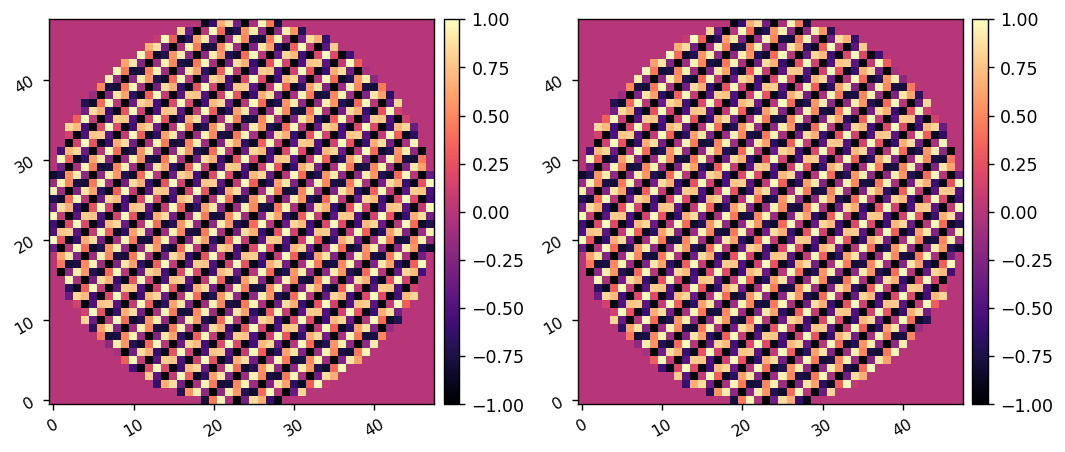

(3480, 4608)


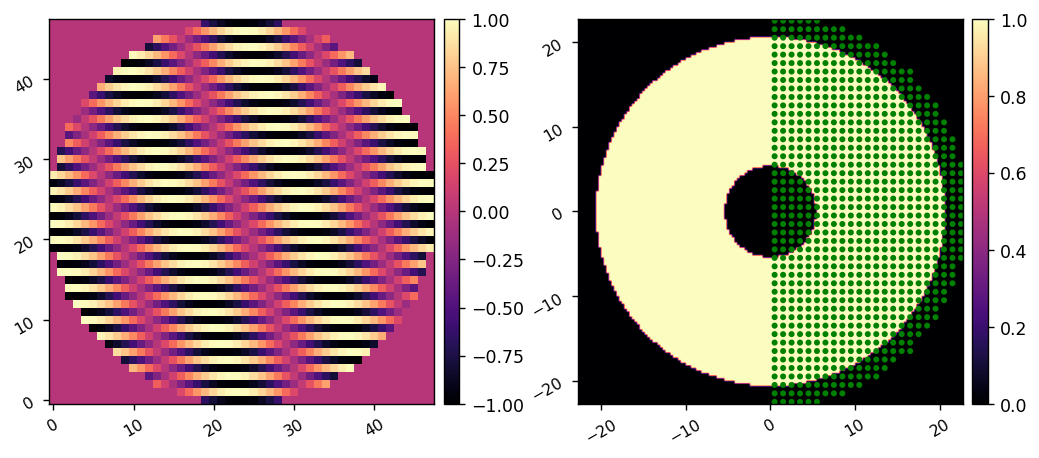

In [6]:
fourier_mask = utils.create_annular_focal_plane_mask(mode, inner_radius=5.4, outer_radius=20.6, edge=0, plot=True)
fourier_mask = utils.create_annular_focal_plane_mask(mode, inner_radius=0.5, outer_radius=23, edge=0, plot=True)
calib_modes, fs = utils.create_fourier_modes(mode, fourier_mask, fourier_sampling=1, ndms=2, return_fs=True)
Nfourier = calib_modes.shape[0]//2
print(calib_modes.shape)
i = 100
imshow2(calib_modes[i,:mode.Nact**2].reshape(mode.Nact,mode.Nact), 
        calib_modes[i+Nfourier,mode.Nact**2:].reshape(mode.Nact,mode.Nact))

patches = []
for f in fs:
    center = (f[0], f[1])
    radius = 0.25
    patches.append(Circle(center, radius, fill=True, color='g'))
print(calib_modes.shape)
imshow2(calib_modes[1, :mode.Nact**2].reshape(mode.Nact,mode.Nact), control_mask, 
             patches2=patches, pxscl2=mode.psf_pixelscale_lamD)


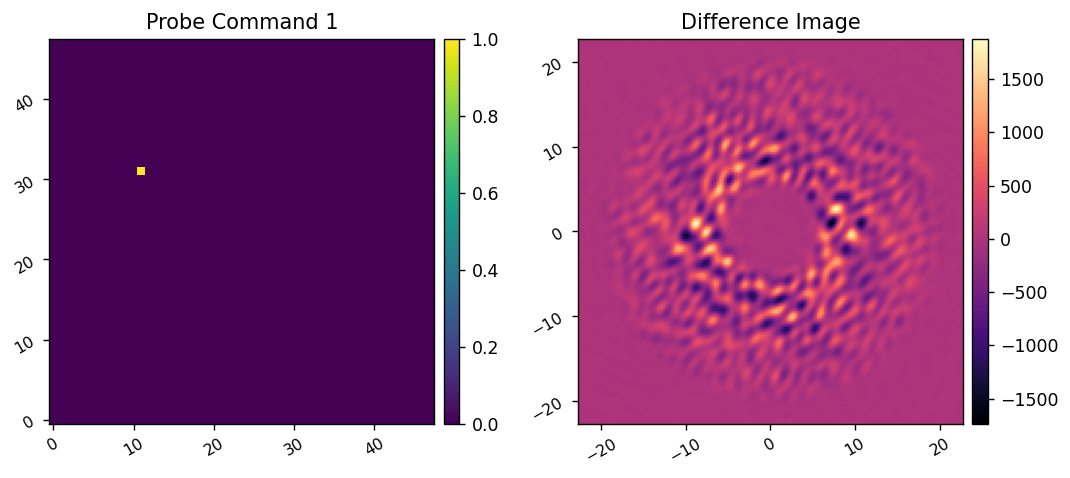

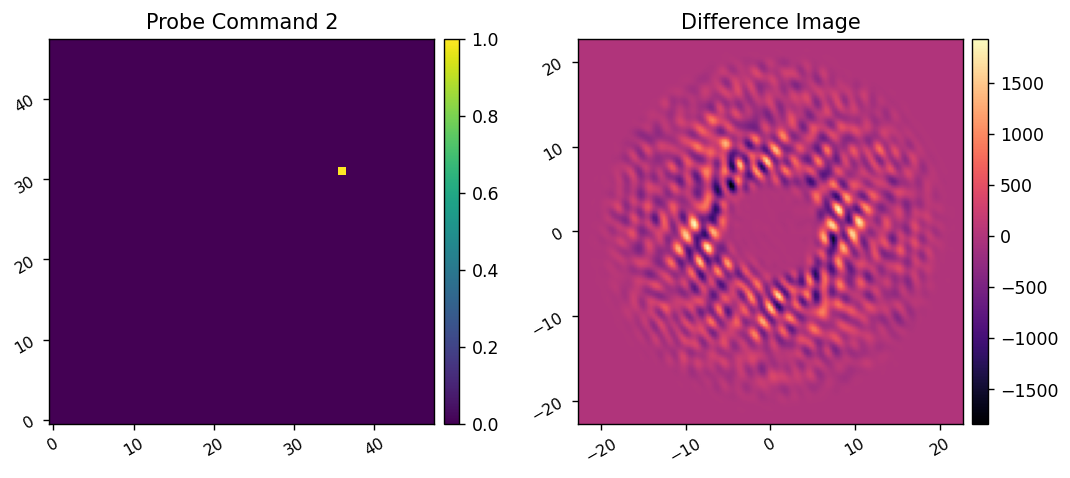

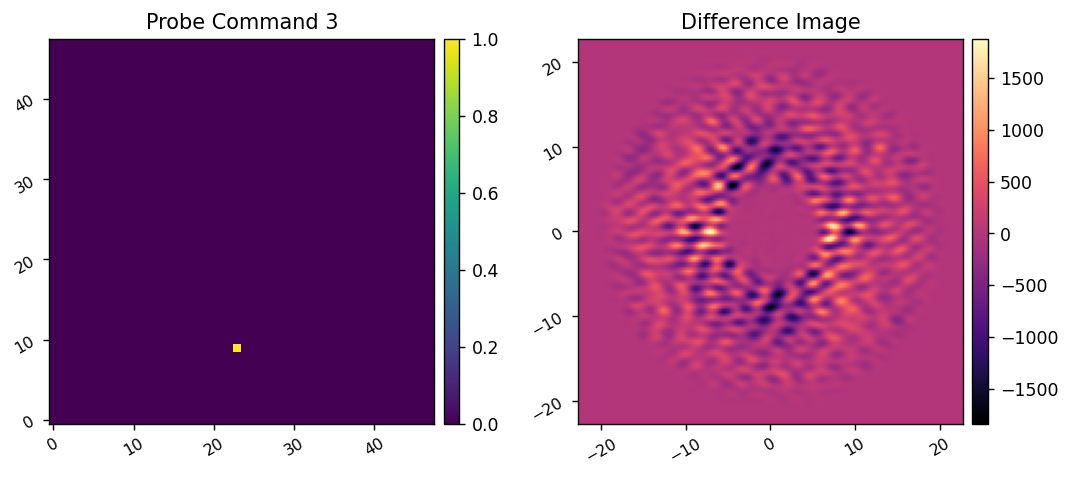

In [13]:
reload(iefc_2dm)

differential_images, single_images = iefc_2dm.take_measurement(mode, probe_modes, probe_amp, return_all=True, plot=True)
ims = differential_images.reshape(probe_modes.shape[0], mode.npsf, mode.npsf)

In [21]:
mode.reset_dms()

Calibrating iEFC...
	Calibrated mode 10/10 in 23.140s
Calibration complete.


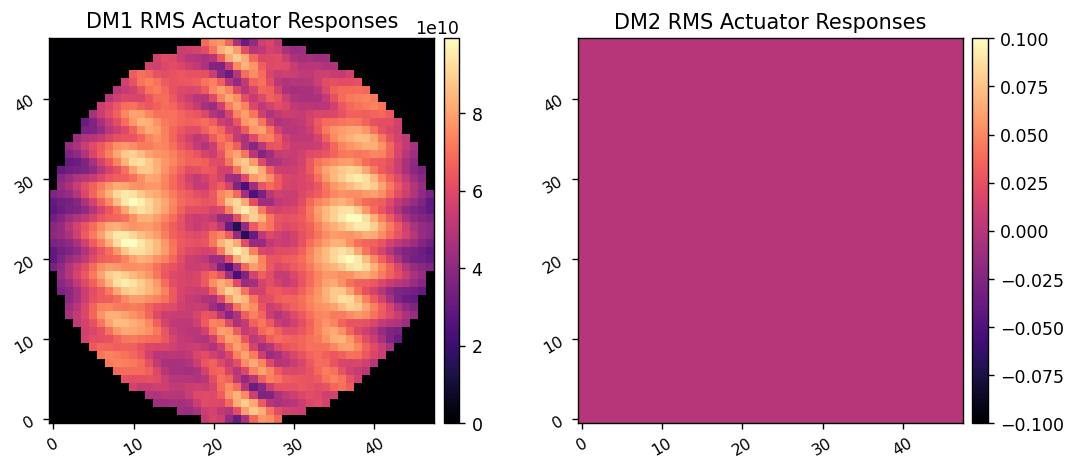

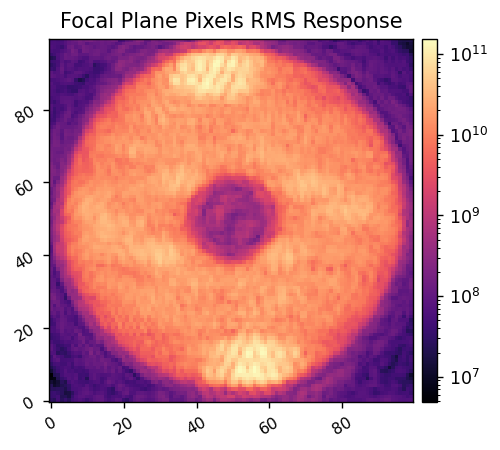

In [25]:
reload(iefc_2dm)

calib_amp = 5e-9
calib_modes = fourier_modes[:10]

response_matrix, response_cube = iefc_2dm.calibrate(mode, 
                                                    control_mask,
                                                    probe_amp, probe_modes, 
                                                         calib_amp, calib_modes, 
                                                         return_all=True)


In [7]:
date = 20230926
date = 20231013
date = 20231218
date = 20231221
response_matrix = xp.array(fits.getdata(response_dir/f'spc_wide_825_fourier_modes_response_matrix_{date}.fits'))
# response_cube = xp.array(fits.getdata(data_dir/response_dir/f'spc_wide_825_fourier_modes_response_cube_{date}.fits'))

In [9]:
3934552233061.1934/2794403703.275511

1408.0113866329468

2228668722618.7104


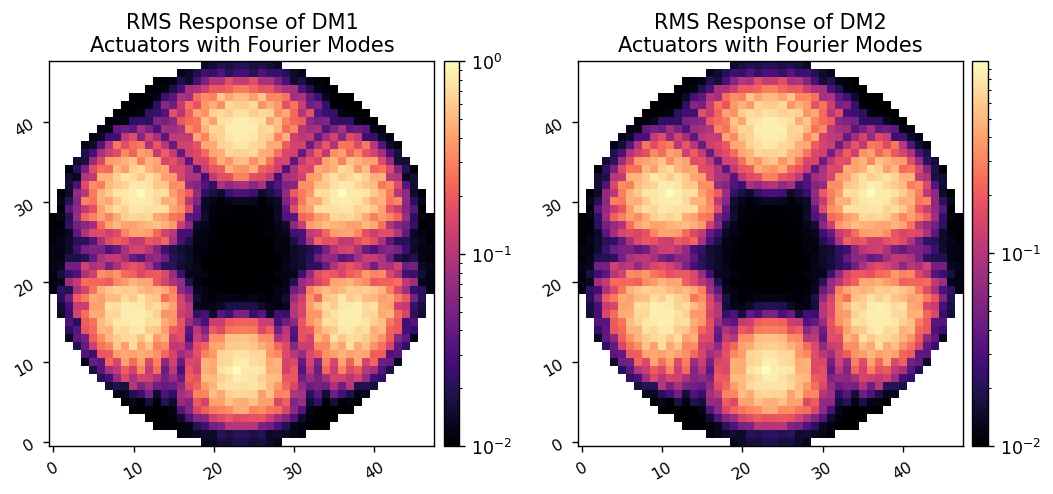

In [8]:
response_matrix.shape

dm_response = xp.sqrt(xp.mean(response_matrix.dot(xp.array(calib_modes))**2, axis=0))
dm1_response = dm_response[:mode.Nact**2].reshape(mode.Nact, mode.Nact)/dm_response.max()
dm2_response = dm_response[mode.Nact**2:].reshape(mode.Nact, mode.Nact)/dm_response.max()

print(dm_response.max())
imshow2(dm1_response, dm2_response, 
        'RMS Response of DM1\nActuators with Fourier Modes', 'RMS Response of DM2\nActuators with Fourier Modes',
        lognorm=True, vmin1=0.01, vmin2=0.01,
        )

2228668722618.7104


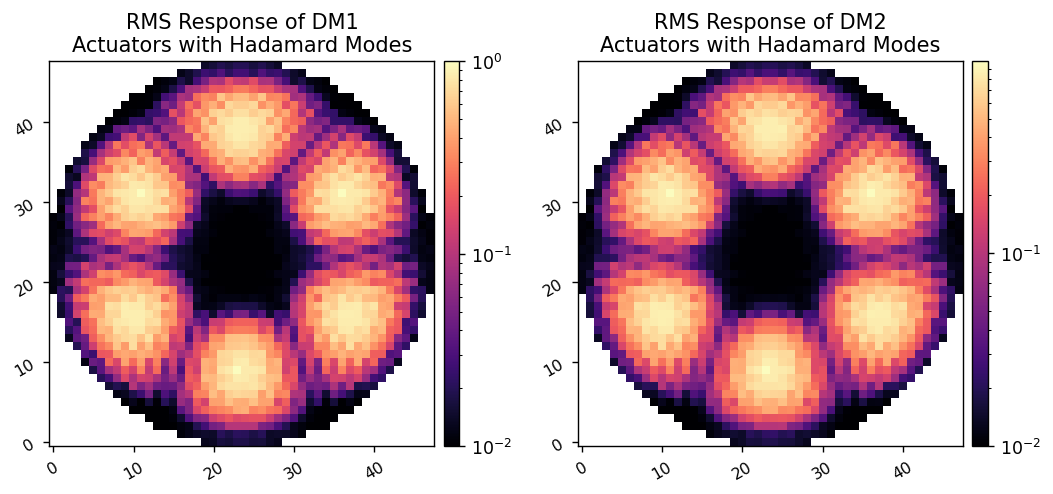

In [9]:
response_matrix.shape

dm_response = xp.sqrt(xp.mean(response_matrix.dot(xp.array(calib_modes))**2, axis=0))
dm1_response = dm_response[:mode.Nact**2].reshape(mode.Nact, mode.Nact)/dm_response.max()
dm2_response = dm_response[mode.Nact**2:].reshape(mode.Nact, mode.Nact)/dm_response.max()

print(dm_response.max())
imshow2(dm1_response, dm2_response, 
        'RMS Response of DM1\nActuators with Hadamard Modes', 'RMS Response of DM2\nActuators with Hadamard Modes',
        lognorm=True, vmin1=0.01, vmin2=0.01,
        )

# Run IEFC

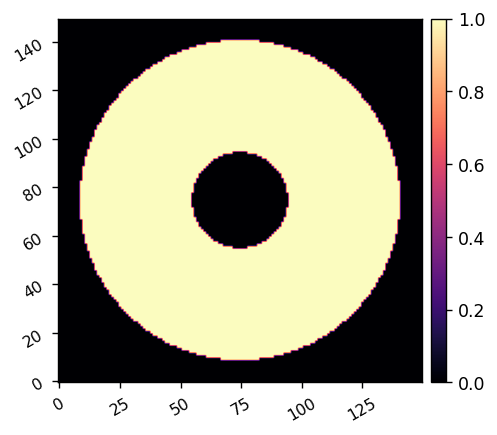

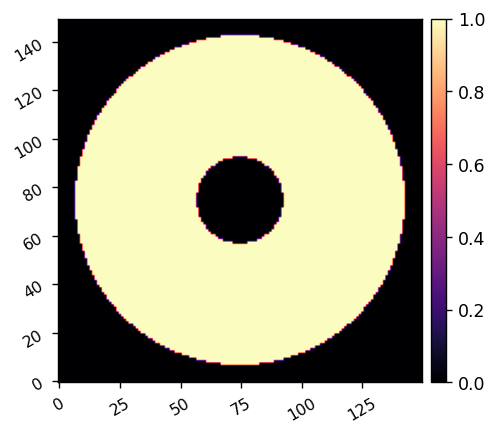

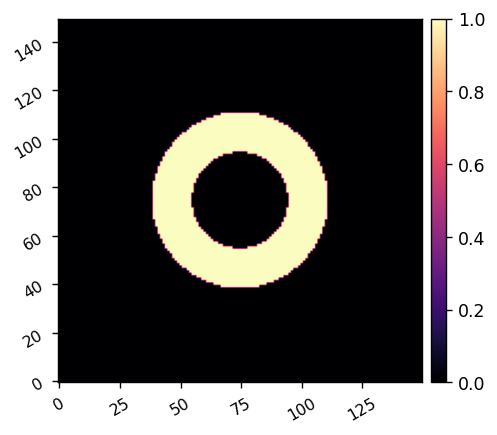

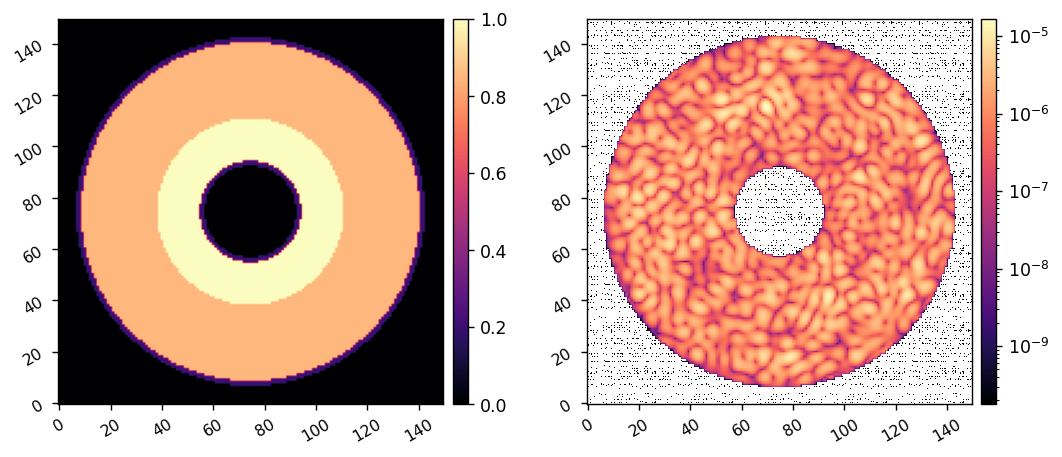

1.409806746664682e-06


In [10]:
reload(utils)
roi1 = utils.create_annular_focal_plane_mask(mode, inner_radius=6, outer_radius=20, edge=None, plot=True)
roi2 = utils.create_annular_focal_plane_mask(mode, inner_radius=5.4, outer_radius=20.6, edge=None, plot=True)
roi3 = utils.create_annular_focal_plane_mask(mode, inner_radius=6, outer_radius=11, edge=None, plot=True)

relative_weight_1 = 0.85
relative_weight_2 = 0.2
weight_map = roi3 + relative_weight_1*(roi1*~roi3) + relative_weight_2*(roi2*~roi1*~roi3)
control_mask = weight_map>0
imshow2(weight_map, control_mask*ref_im, lognorm2=True)
mean_ni = xp.mean(ref_im[control_mask])
print(mean_ni)

In [9]:
mode.reset_dms()

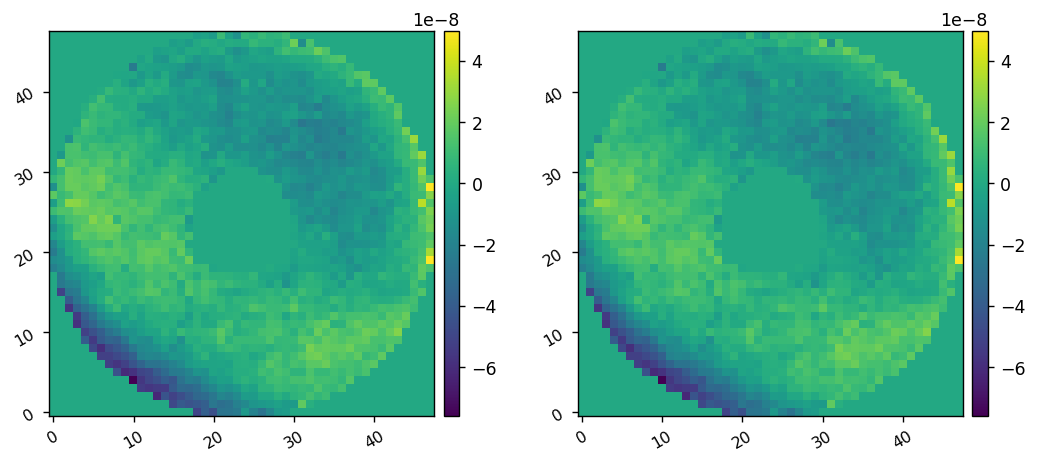

In [15]:
mode.reset_dms()
imshow2(mode.get_dm1(), mode.get_dm2(), cmap1='viridis', cmap2='viridis')
images = xp.array([ref_im])
dm1_commands = xp.array([mode.get_dm1()])
dm2_commands = xp.array([mode.get_dm2()])
regs = xp.array([])

In [33]:
reg_cond = 1e-4
control_matrix = utils.WeightedLeastSquares(response_matrix, rcond=reg_cond, weight_map=weight_map, nprobes=probe_modes.shape[0])
# control_matrix = utils.TikhonovInverse(response_matrix, 1e-2)


In [32]:
reg_fun = utils.beta_reg
reg_conds = -2
# reg_conds = np.linspace(-7, -1, 7)
# reg_conds = -4.5

Running iEFC...
	Closed-loop iteration 25 / 27


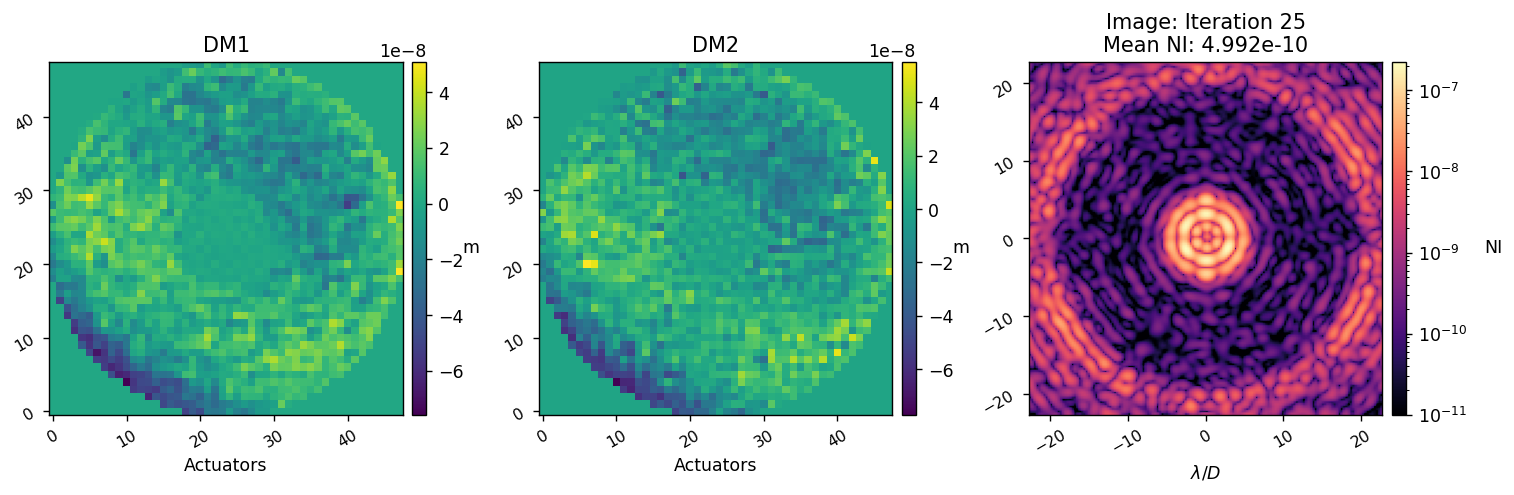

	Closed-loop iteration 26 / 27


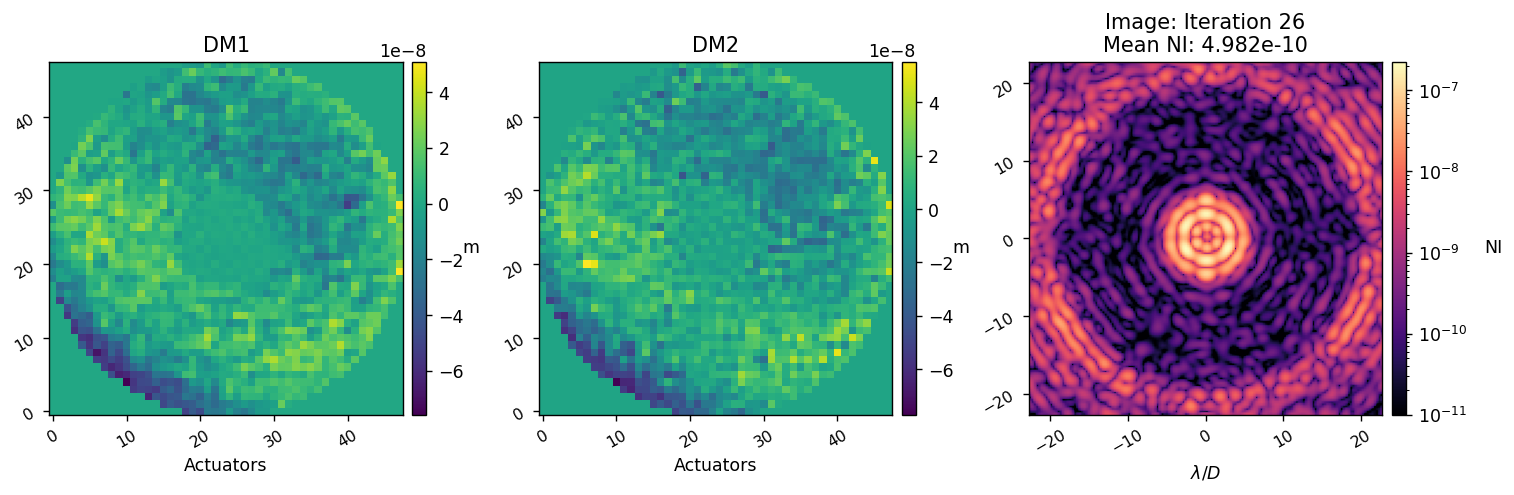

	Closed-loop iteration 27 / 27


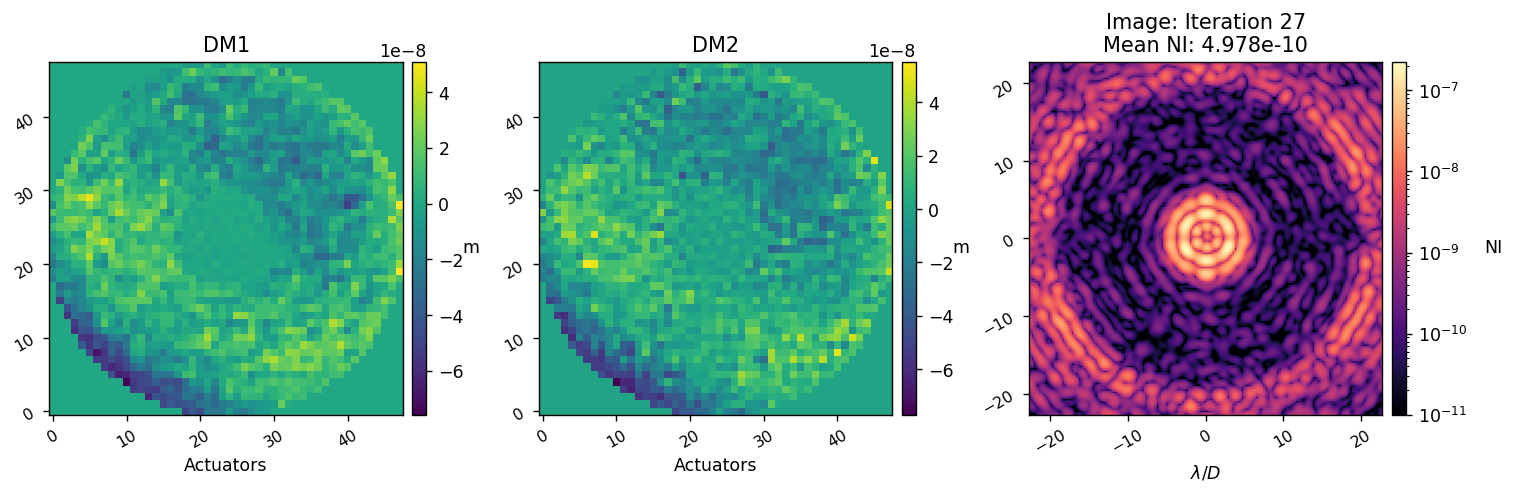

Closed loop for given control matrix completed in 8.754s.


In [33]:
reload(iefc_2dm)
reload(utils)

images, dm1_commands, dm2_commands, regs = iefc_2dm.run(mode, 
                                                        response_matrix,
                                                        reg_fun, reg_conds,
                                                        probe_modes, 
                                                        probe_amp, 
                                                        calib_modes,
                                                        control_mask, 
                                                        num_iterations=3, 
                                                        loop_gain=0.5, 
                                                        leakage=0,
                                                        plot_all=True,
                                                        plot_radial_contrast=False,
                                                        plot_probes=False,
                                                        old_images=images,
                                                        old_dm1_commands=dm1_commands,
                                                        old_dm2_commands=dm2_commands,
                                                        old_regs=regs,
                                                        )

In [34]:
date

20231221

In [35]:
utils.save_fits(response_dir/f'spc_wfov_825_fourier_modes_dm1_commands_{date}.fits', dm1_commands)
utils.save_fits(response_dir/f'spc_wfov_825_fourier_modes_dm2_commands_{date}.fits', dm2_commands)
utils.save_fits(response_dir/f'spc_wfov_825_fourier_modes_images_{date}.fits', images)
utils.save_fits(response_dir/f'spc_wfov_825_fourier_modes_regs_{date}.fits', regs)

Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/spc_wfov_825_fourier_modes_dm1_commands_20231221.fits
Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/spc_wfov_825_fourier_modes_dm2_commands_20231221.fits
Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/spc_wfov_825_fourier_modes_images_20231221.fits
Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/spc_wfov_825_fourier_modes_regs_20231221.fits


Mean NI = 4.297e-08


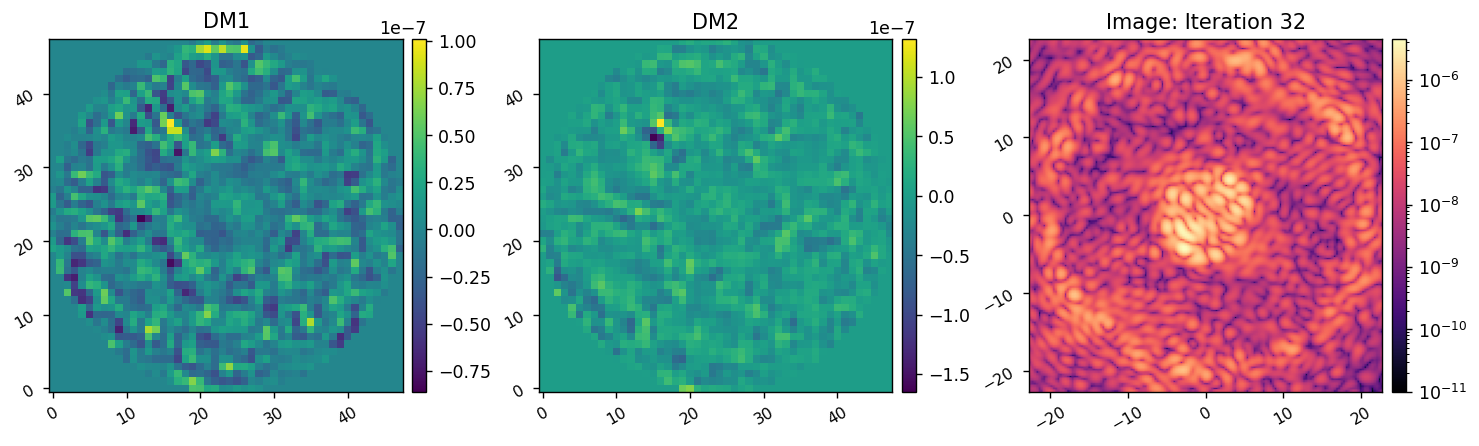

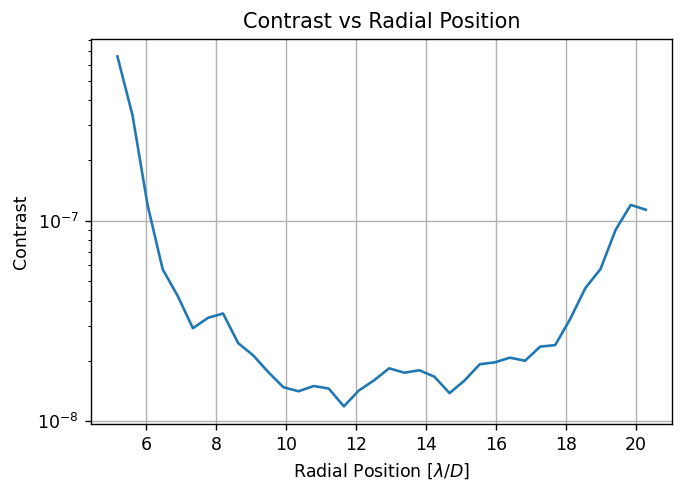

In [59]:
i = 33

ni = xp.mean(images[i][control_mask])
print(f'Mean NI = {ni:.3e}')

imshow3(dm1_commands[i], dm2_commands[i], images[i], 
        'DM1', 'DM2', f'Image: Iteration {i-1}',
        cmap1='viridis', cmap2='viridis',
        pxscl3=mode.psf_pixelscale_lamD,
        lognorm3=True, vmin3=1e-11)
utils.plot_radial_contrast(images[i], control_mask, pixelscale=mode.psf_pixelscale_lamD, nbins=75)
